<a href="https://colab.research.google.com/github/srJboca/segmentacion/blob/main/4.%20Prediccion%20con%20Ing%20de%20Datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Predicción de Mora con PCA

## Introducción

Este notebook te guiará a través de la construcción de un modelo para predecir la 'Mora' (incumplimiento de pago) de los clientes. Exploraremos el uso del Análisis de Componentes Principales (PCA) para la reducción de dimensionalidad antes de entrenar un clasificador binario.

**Puntos Clave del Tutorial:**
1.  Preparación de datos para la predicción.
2.  Aplicación de PCA para reducir la dimensionalidad del conjunto de características.
3.  Entrenamiento y evaluación de un modelo de clasificación binaria utilizando los componentes principales.
4.  Un método para estimar la importancia de las características originales después de aplicar PCA.

Este enfoque iterativo es común en el desarrollo de modelos de machine learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

### Descarga y Carga del DataFrame Preprocesado

Utilizaremos el archivo `df_analisis.parquet`.

In [2]:
!wget -N https://github.com/srJboca/segmentacion/raw/refs/heads/main/archivos/df_analisis.parquet
df_analisis = pd.read_parquet('df_analisis.parquet')

--2025-06-03 04:03:43--  https://github.com/srJboca/segmentacion/raw/refs/heads/main/archivos/df_analisis.parquet
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/srJboca/segmentacion/refs/heads/main/archivos/df_analisis.parquet [following]
--2025-06-03 04:03:43--  https://raw.githubusercontent.com/srJboca/segmentacion/refs/heads/main/archivos/df_analisis.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75105565 (72M) [application/octet-stream]
Saving to: ‘df_analisis.parquet’

df_analisis.parquet 100%[===================>]  71.63M  79.2MB/s    in 0.9s    

Last-modified header missing -- 

## 2. Revisión Rápida de Datos
Recordemos la estructura del DataFrame `df_analisis`.

In [3]:
print("--- Primeras 5 filas de df_analisis ---")
print(df_analisis.head())
print("\n--- Información de df_analisis ---")
df_analisis.info()

--- Primeras 5 filas de df_analisis ---
                      Numero de factura                    Numero de contrato  \
0  886199bb-77c8-43e2-86a0-a53348fa2706  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
1  886199bb-77c8-43e2-86a0-a53348fa2706  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
2  6848b692-4212-4738-a35c-1f8c0d383e3d  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
3  ad91361e-9b8d-491e-bef9-e690e9b28faf  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   
4  e77f7ac6-734b-4856-a5c3-1a32d845e6b6  ba70b7fa-aef4-492a-9d45-13a0c63ce47c   

  Fecha de Emision  Consumo (m3) Fecha de Pago Oportuno Fecha de Lectura  \
0       2021-01-06         11.51             2021-01-19       2020-12-28   
1       2021-01-06         11.51             2021-01-19       2020-12-28   
2       2021-03-02         10.26             2021-03-17       2021-02-20   
3       2021-04-01         14.96             2021-04-11       2021-03-27   
4       2021-05-10         14.89             2021-05-21       2021-05-05   

  Fecha de Suspe

In [4]:
df_filtrado = df_analisis[[
    'Numero de factura',
    'Consumo (m3)',
    'Estrato',
    'Precio m3 (COP)',
    'Dias_Emision_PagoOportuno',
    'Dias_Lectura_Emision',
    'Dias_PagoOportuno_PagoReal',
    'Mora'
]].copy()

# Verificar las primeras filas y la información del dataframe filtrado
print("\n--- Primeras 5 filas del DataFrame filtrado ---")
print(df_filtrado.head())
print("\n--- Información del DataFrame filtrado ---")
df_filtrado.info()


--- Primeras 5 filas del DataFrame filtrado ---
                      Numero de factura  Consumo (m3)    Estrato  \
0  886199bb-77c8-43e2-86a0-a53348fa2706         11.51  Estrato 1   
1  886199bb-77c8-43e2-86a0-a53348fa2706         11.51  Estrato 1   
2  6848b692-4212-4738-a35c-1f8c0d383e3d         10.26  Estrato 1   
3  ad91361e-9b8d-491e-bef9-e690e9b28faf         14.96  Estrato 1   
4  e77f7ac6-734b-4856-a5c3-1a32d845e6b6         14.89  Estrato 1   

   Precio m3 (COP)  Dias_Emision_PagoOportuno  Dias_Lectura_Emision  \
0              588                         13                     9   
1              588                         13                     9   
2              588                         15                    10   
3              637                         10                     5   
4              637                         11                     5   

   Dias_PagoOportuno_PagoReal  Mora  
0                          -4     0  
1                          -4     0  
2

In [5]:
# Convertir 'Estrato socioeconomico' a numérico (ordinal)

if df_filtrado['Estrato'].dtype == 'object' or isinstance(df_filtrado['Estrato'].dtype, pd.CategoricalDtype):
    df_filtrado['Estrato_Num'] = df_filtrado['Estrato'].str.replace('Estrato ', '', regex=False).astype(int)
else:
    df_filtrado['Estrato_Num'] = df_filtrado['Estrato'].astype(int)

features_for_pca = [
    'Consumo (m3)',
    'Estrato_Num',
    'Precio m3 (COP)',
    'Dias_Emision_PagoOportuno',
    'Dias_Lectura_Emision',
    'Dias_PagoOportuno_PagoReal',
]
X = df_filtrado[features_for_pca].copy()

print(f"Shape antes de dropna: {X.shape}")
X.dropna(inplace=True) # Eliminar filas con NaNs en estas características
print(f"Shape después de dropna: {X.shape}")

print("\nValores faltantes después de dropna:")
print(X.isnull().sum())

Shape antes de dropna: (2400000, 6)
Shape después de dropna: (2400000, 6)

Valores faltantes después de dropna:
Consumo (m3)                  0
Estrato_Num                   0
Precio m3 (COP)               0
Dias_Emision_PagoOportuno     0
Dias_Lectura_Emision          0
Dias_PagoOportuno_PagoReal    0
dtype: int64


### 3. Escalado de Características
PCA es sensible a la escala de las características. Por lo tanto, estandarizaremos los datos.

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("--- Datos escalados (primeras 5 filas) ---")
print(pd.DataFrame(X_scaled, columns=X.columns).head())

--- Datos escalados (primeras 5 filas) ---
   Consumo (m3)  Estrato_Num  Precio m3 (COP)  Dias_Emision_PagoOportuno  \
0     -0.228758    -1.173305        -1.285281                   0.293913   
1     -0.228758    -1.173305        -1.285281                   0.293913   
2     -0.517315    -1.173305        -1.285281                   1.464782   
3      0.567660    -1.173305        -1.196012                  -1.462391   
4      0.551500    -1.173305        -1.196012                  -0.876957   

   Dias_Lectura_Emision  Dias_PagoOportuno_PagoReal  
0              0.879353                   -0.606847  
1              0.879353                   -0.606847  
2              1.464965                   -0.243007  
3             -1.463097                   -0.849407  
4             -1.463097                   -1.334527  


## 4. Análisis de Componentes Principales (PCA)

Reduciremos la dimensionalidad a 2 componentes principales para visualización.

In [7]:
pca = PCA(n_components=2) # Reducir a 2 componentes
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data=X_pca, columns=['principal_component_1', 'principal_component_2'])

print("--- Componentes Principales (primeras 5 filas) ---")
print(df_pca.head())

print(f"\nVarianza explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Varianza explicada total (2 componentes): {pca.explained_variance_ratio_.sum():.2f}")

--- Componentes Principales (primeras 5 filas) ---
   principal_component_1  principal_component_2
0              -1.738267               0.370237
1              -1.738267               0.370237
2              -1.740956               1.580683
3              -1.670564              -2.089884
4              -1.670267              -1.945082

Varianza explicada por cada componente: [0.25619879 0.16692274]
Varianza explicada total (2 componentes): 0.42


In [8]:
df_pca = df_pca.set_index(X.index)
df_pca = df_pca.join(df_filtrado[['Mora']])

print("\n--- df_pca con la columna 'Mora' (primeras 5 filas) ---")
print(df_pca.head())

print("\n--- Información de df_pca ---")
df_pca.info()


--- df_pca con la columna 'Mora' (primeras 5 filas) ---
   principal_component_1  principal_component_2  Mora
0              -1.738267               0.370237     0
1              -1.738267               0.370237     0
2              -1.740956               1.580683     0
3              -1.670564              -2.089884     0
4              -1.670267              -1.945082     0

--- Información de df_pca ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400000 entries, 0 to 2399999
Data columns (total 3 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   principal_component_1  float64
 1   principal_component_2  float64
 2   Mora                   int64  
dtypes: float64(2), int64(1)
memory usage: 54.9 MB


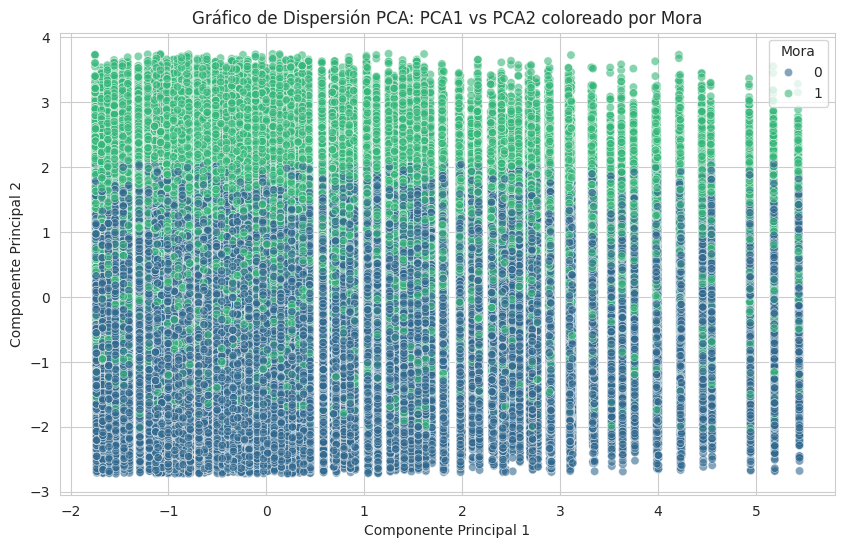

In [9]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='principal_component_1',
    y='principal_component_2',
    hue='Mora',  # Colorear los puntos según el valor de 'Mora' (0 o 1)
    data=df_pca,
    palette='viridis', # Opcional: cambia la paleta de colores
    alpha=0.6 # Opcional: ajusta la transparencia de los puntos
)

plt.title('Gráfico de Dispersión PCA: PCA1 vs PCA2 coloreado por Mora')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()


Tamaño del conjunto de entrenamiento: 1680000
Tamaño del conjunto de prueba: 720000
Proporción de 'Mora' en el conjunto de entrenamiento: Mora
0    0.749851
1    0.250149
Name: proportion, dtype: float64
Proporción de 'Mora' en el conjunto de prueba: Mora
0    0.74985
1    0.25015
Name: proportion, dtype: float64

--- Evaluación del Modelo ---
Accuracy: 0.7798

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87    539892
           1       0.68      0.23      0.34    180108

    accuracy                           0.78    720000
   macro avg       0.73      0.60      0.60    720000
weighted avg       0.76      0.78      0.74    720000


Matriz de Confusión:
[[520444  19448]
 [139075  41033]]


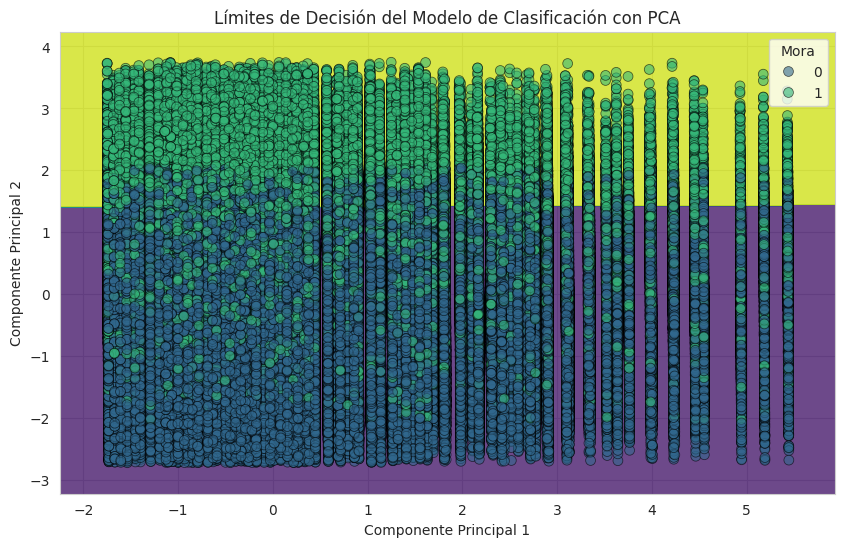

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Definir las características (PCA componentes) y la variable objetivo
X_model = df_pca[['principal_component_1', 'principal_component_2']]
y_model = df_pca['Mora']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.3, random_state=42, stratify=y_model) # Stratify para mantener la proporción de 'Mora'

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")
print(f"Proporción de 'Mora' en el conjunto de entrenamiento: {y_train.value_counts(normalize=True)}")
print(f"Proporción de 'Mora' en el conjunto de prueba: {y_test.value_counts(normalize=True)}")

# Inicializar y entrenar el modelo de Regresión Logística
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
print("\n--- Evaluación del Modelo ---")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

# Opcional: Visualizar los límites de decisión (solo funciona bien para 2 componentes)
# Puedes ejecutar esta parte para ver cómo el modelo separa las clases en el espacio PCA.

# Crear una cuadrícula para plotear los límites de decisión
x_min, x_max = X_model['principal_component_1'].min() - 0.5, X_model['principal_component_1'].max() + 0.5
y_min, y_max = X_model['principal_component_2'].min() - 0.5, X_model['principal_component_2'].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predecir la clase para cada punto en la cuadrícula
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotear los límites de decisión y los puntos de datos
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis') # Colores de fondo para las regiones

sns.scatterplot(
    x='principal_component_1',
    y='principal_component_2',
    hue='Mora',
    data=df_pca,
    palette='viridis',
    alpha=0.6,
    edgecolor='k', # Añadir borde a los puntos para mejor visibilidad
    s=50 # Ajustar tamaño de los puntos
)

plt.title('Límites de Decisión del Modelo de Clasificación con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid(True)
plt.show()



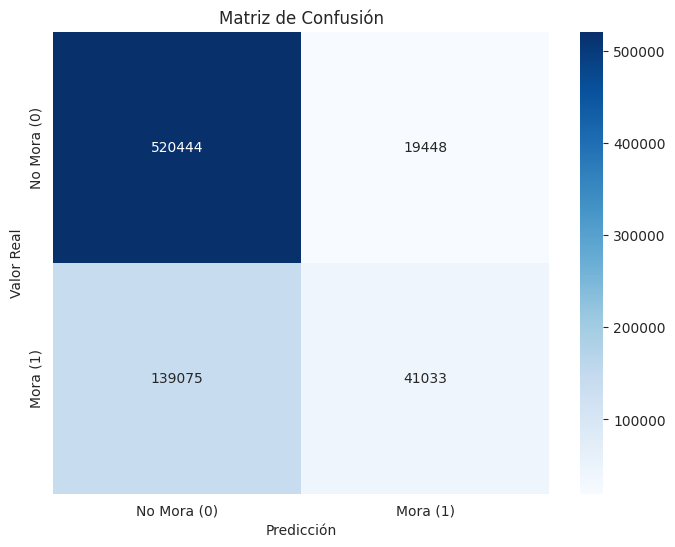


--- Explicación de la Matriz de Confusión ---
La matriz de confusión muestra el rendimiento de nuestro modelo en el conjunto de prueba.
Las filas representan las clases reales (Valor Real), y las columnas representan las clases predichas (Predicción).
Tenemos 4 celdas principales:
  - Arriba a la izquierda (True Negatives, TN): 520444 casos donde el valor real era 0 (No Mora) y el modelo predijo 0 (No Mora).
  - Arriba a la derecha (False Positives, FP): 19448 casos donde el valor real era 0 (No Mora) pero el modelo predijo 1 (Mora). Estos son errores de 'Tipo I'.
  - Abajo a la izquierda (False Negatives, FN): 139075 casos donde el valor real era 1 (Mora) pero el modelo predijo 0 (No Mora). Estos son errores de 'Tipo II'.
  - Abajo a la derecha (True Positives, TP): 41033 casos donde el valor real era 1 (Mora) y el modelo predijo 1 (Mora).

A partir de estos valores, se calculan métricas como:
  - Accuracy = (TN + TP) / Total de casos = (520444 + 41033) / 720000 = 0.7798
  - Precisio

In [11]:
# Visualizar la Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Mora (0)', 'Mora (1)'],
            yticklabels=['No Mora (0)', 'Mora (1)'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

# Explicación de la Matriz de Confusión
print("\n--- Explicación de la Matriz de Confusión ---")
print(f"La matriz de confusión muestra el rendimiento de nuestro modelo en el conjunto de prueba.")
print(f"Las filas representan las clases reales (Valor Real), y las columnas representan las clases predichas (Predicción).")
print(f"Tenemos 4 celdas principales:")
print(f"  - Arriba a la izquierda (True Negatives, TN): {cm[0, 0]} casos donde el valor real era 0 (No Mora) y el modelo predijo 0 (No Mora).")
print(f"  - Arriba a la derecha (False Positives, FP): {cm[0, 1]} casos donde el valor real era 0 (No Mora) pero el modelo predijo 1 (Mora). Estos son errores de 'Tipo I'.")
print(f"  - Abajo a la izquierda (False Negatives, FN): {cm[1, 0]} casos donde el valor real era 1 (Mora) pero el modelo predijo 0 (No Mora). Estos son errores de 'Tipo II'.")
print(f"  - Abajo a la derecha (True Positives, TP): {cm[1, 1]} casos donde el valor real era 1 (Mora) y el modelo predijo 1 (Mora).")

print(f"\nA partir de estos valores, se calculan métricas como:")
print(f"  - Accuracy = (TN + TP) / Total de casos = ({cm[0, 0]} + {cm[1, 1]}) / {np.sum(cm):.0f} = {accuracy:.4f}")
print(f"  - Precision (para la clase 1, Mora) = TP / (TP + FP) = {cm[1, 1]} / ({cm[1, 1]} + {cm[0, 1]}): Proporción de predicciones positivas (Mora) que fueron correctas.")
print(f"  - Recall (Sensibilidad, para la clase 1, Mora) = TP / (TP + FN) = {cm[1, 1]} / ({cm[1, 1]} + {cm[1, 0]}): Proporción de casos reales positivos (Mora) que fueron identificados correctamente.")
print(f"  - F1-Score (para la clase 1, Mora): Media armónica de Precision y Recall, útil cuando hay un desbalance de clases.")
print(f"Estas métricas, especialmente Precision y Recall, nos dan una visión más detallada del rendimiento del modelo, particularmente en la identificación de casos de 'Mora', que puede ser la clase de interés principal.")
